In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [65]:
with open("OLtest_raw_data.txt", "r") as file:
    raw_data = file.read().strip().split("ModeConstantDC")[1:-1]

ndata = len(raw_data)
columns = list(map(lambda x: (x.split(" = ")[0]), raw_data[0].strip().split("\n")))

data_np = np.zeros((len(columns), ndata))
for i in range(ndata):
    data_np[:,i] = list(map(lambda x: float(x.split(" = ")[-1]), raw_data[i].strip().split("\n")))

data = pd.DataFrame(data_np.T, columns=columns)
data.insert(0,"time",np.cumsum(data["dt"]),False)
print(str(data.columns))

Index(['time', 'dt', 'xpos', 'ypos', 'thetapos', 'vfwd', 'omega', 'speed_left',
       'speed_right', 'dc left', 'dc right'],
      dtype='object')


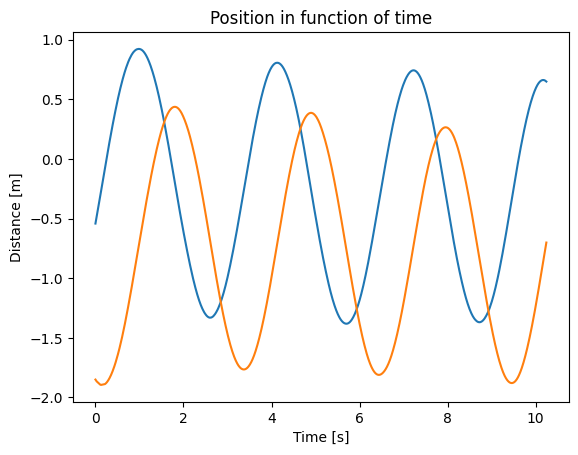

In [72]:
plt.title("Position in function of time")
plt.plot(data["time"], data["xpos"], label="x")
plt.plot(data["time"], data["ypos"], label="y")
plt.xlabel("Time [s]")
plt.ylabel("Distance [m]")
plt.show()

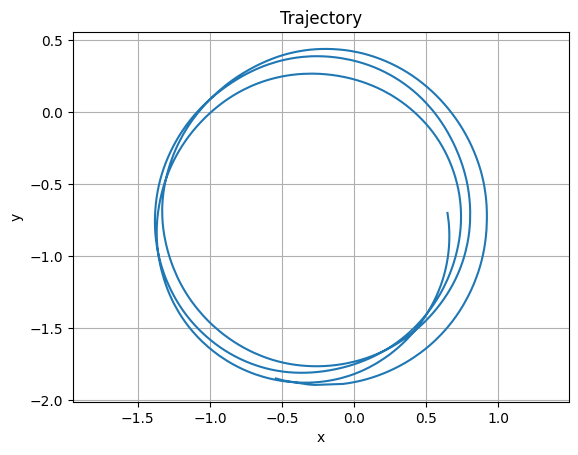

In [78]:
plt.title("Trajectory")
plt.plot(data["xpos"], data["ypos"])
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid()
plt.show()

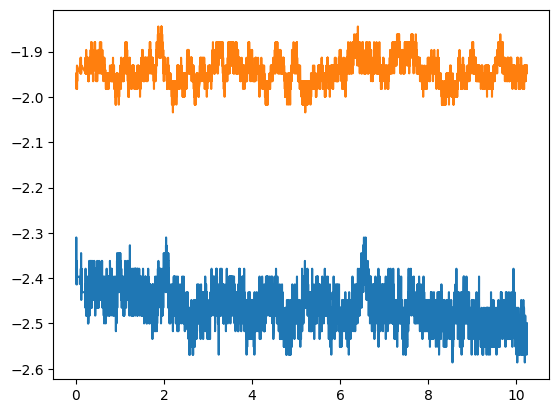

In [80]:
plt.plot(data["time"], data["speed_left"])
plt.plot(data["time"], data["speed_right"])
plt.show()